# **Installs**

In [ ]:
!pip install hcipy --upgrade --quiet

In [ ]:
!pip install --force-reinstall jsonschema==3.2.0 --quiet

     |████████████████████████████████| 56 kB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 11.6 MB/s 
     |████████████████████████████████| 60 kB 6.7 MB/s 
     |████████████████████████████████| 117 kB 69.1 MB/s 


In [1]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet

In [2]:
!pip install photutils --quiet

     |████████████████████████████████| 826 kB 5.1 MB/s 


In [3]:
!pip install pyxel-sim[all] --quiet

     |████████████████████████████████| 1.3 MB 5.3 MB/s 
     |████████████████████████████████| 134 kB 52.8 MB/s 
     |████████████████████████████████| 8.7 MB 41.8 MB/s 
     |████████████████████████████████| 164 kB 65.8 MB/s 
     |████████████████████████████████| 11.5 MB 44.9 MB/s 
     |████████████████████████████████| 13.3 MB 26.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 144 kB 47.2 MB/s 
     |████████████████████████████████| 271 kB 46.7 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 341 kB 40.6 MB/s 
     |████████████████████████████████| 428 kB 63.6 MB/s 
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 130 kB 41.6 MB/s 
     |███

Run above cells and restart runtime. Continue to run the cells below.

# **Imports**

In [32]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

import pyxel
import poppy
import yaml
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.table import Table

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from astropy.wcs import WCS

from photutils import aperture as aper
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture

from scipy.stats import norm

import os
from time import perf_counter
import json
import requests

import mastcasjobs
#from hcipy import *

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('dark')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **GitHub**

In [2]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1025, done.
remote: Counting objects: 100% (650/650), done.
remote: Compressing objects: 100% (646/646), done.
remote: Total 1025 (delta 376), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (1025/1025), 118.20 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [3]:
cd /content/INSIST/data

/content/INSIST/data


# **Detector Simulator**

In [4]:
!pyxel download-examples

Done.


In [105]:
hdu = fits.open('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')

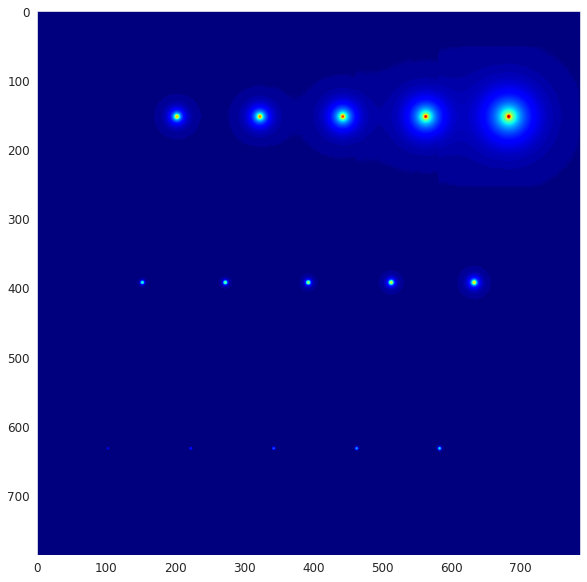

In [107]:
data= hdu[0].data
plt.imshow(data, cmap = 'jet', norm = col.LogNorm())

In [108]:
hdu_n = fits.PrimaryHDU(data,header = hdu[0].header)
hdul = fits.HDUList(hdu_n)
hdul.writeto('/content/INSIST/data/pyxel-examples/tutorial/data/source_m.fits',overwrite = True)

In [109]:
with open("/content/INSIST/data/exposure_on.yaml",'r') as f:
  dat = yaml.load(f)

In [110]:
dat['pipeline']['photon_generation'][0]['arguments']['image_file'] = 'data/source_m.fits'

In [ ]:
205

In [153]:
dat['pipeline']['optics'][0]['arguments']['fov_arcsec'] = 20.5
dat['pipeline']['optics'][0]['arguments']['fov_arcsec']

20.5

In [154]:
dat['ccd_detector']['geometry']['row']= data.shape[0]
dat['ccd_detector']['geometry']['col']= data.shape[1]
dat['ccd_detector']['geometry']['total_thickness'] = dat['ccd_detector']['geometry']['pixel_vert_size']*dat['ccd_detector']['geometry']['row']

In [155]:
with open("/content/INSIST/data/exposure_on.yaml", 'w') as out:
  yaml.dump(dat,out)

In [156]:
config = pyxel.load("/content/INSIST/data/exposure_on.yaml")
exposure = config.exposure  # class Single
detector = config.ccd_detector  # class CCD
pipeline = config.pipeline  # class DetectionPipeline

In [157]:
pipeline.charge_generation

ModelGroup<name='charge_generation', models=['photoelectrons', 'cosmix']>

In [158]:
cd /content/INSIST/data/pyxel-examples/tutorial

/content/INSIST/data/pyxel-examples/tutorial


In [159]:
result = pyxel.exposure_mode(exposure=exposure, detector=detector, pipeline=pipeline)
result

<xarray.Dataset>
Dimensions:       (readout_time: 1, x: 787, y: 787)
Coordinates:
  * readout_time  (readout_time) int64 1
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 779 780 781 782 783 784 785 786
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 779 780 781 782 783 784 785 786
Data variables:
    image         (readout_time, y, x) uint32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    signal        (readout_time, y, x) float64 2.549e-08 2.245e-08 ... 1.72e-07
    pixel         (readout_time, y, x) float64 8.497e-05 7.484e-05 ... 0.0005733

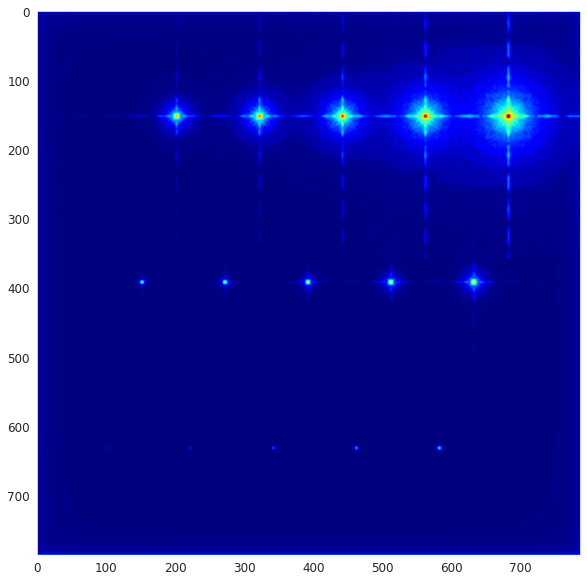

In [160]:
plt.imshow(result.pixel.data[0], cmap = 'jet', norm = col.LogNorm());

In [142]:
result.pixel.data[0].max()/result.pixel.data[0].min()

1142951.6028024943

In [ ]:
hdu_n = fits.PrimaryHDU(result.pixel.data[0],header = hdu[0].header)
hdul = fits.HDUList(hdu_n)
hdul.writeto('/content/INSIST/data/output.fits',overwrite = True)

# **Single PSF Generator**

In [ ]:
fwhm_in = float(input("Enter FWHM of source in arcsecond : ") or "0.3")
ABmag   = float(input("Enter AB magnitude of the source  : ") or "0")

# Flux to AB magnitude
flux = 3631*pow(10,-ABmag/2.5)

pixel_scale = 0.01 #arcsecond

# Input FWHM to detector fwhm conversion
fwhm = fwhm_in/pixel_scale    

# fwhm to sigma conversion
sigma_psf = fwhm*gaussian_fwhm_to_sigma

# Amplitude of a gaussian for given flux and standard deviation.
amplitude_g = flux/(sigma_psf**2*2*np.pi)

amplitude_a = (flux)/(0.8569446798286412*fwhm**2)

# Number of pixels.
n_pix = 512
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]

# Modelling a 2D gaussian at the center of the image.
model_gauss = models.Gaussian2D(amplitude_g, len(x)//2, len(x)//2, sigma_psf, sigma_psf)

# Modelling a Airy Disk of same amplitude.
model_airy = models.AiryDisk2D(amplitude_a, len(x)//2, len(x)//2, fwhm)

image_g = model_gauss(x,y)

image_a = model_airy(x,y)

# Plot
fix, ax = plt.subplots(1,2,figsize=(20,10))

norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(np.log10(1+image_g/image_g.max()),origin='lower',cmap='Greys',vmin=1e-11)
ax[0].set_title(f'Gaussian Model, ABmag = {ABmag}')

ax[1].imshow(image_a,origin='lower',cmap='Greys',norm=norm)
ax[1].set_title(f'Airy Model, ABmag = {ABmag}');

In [ ]:
flux

In [ ]:
on_axis_ssr = np.loadtxt('on_axis1.TXT',skiprows=18,encoding='latin-1')
plt.imshow(np.log10(on_axis_ssr/on_axis_ssr.max()))

In [ ]:
plt.plot(on_axis_ssr[:,len(on_axis_ssr)//2])

In [ ]:
off_axis_ssr = np.loadtxt('off_axis.TXT',skiprows=18,encoding='latin-1')
plt.imshow(np.log10(off_axis_ssr/off_axis_ssr.max()))

In [ ]:
image_g.sum(), flux, image_a.sum()

Airy Disk not modelled properly yet

# **PSF Generator using Source Catalog**


### **M 67 GALEX NUV**

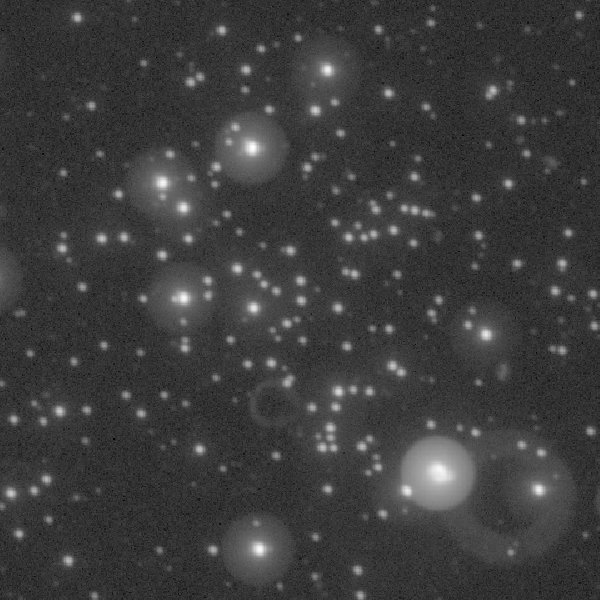

### **GALEX Data**

In [ ]:
df = pd.read_csv('M67.csv')
df = df.rename(columns={'ra':'RA','dec':'Dec'}).drop_duplicates(['RA','Dec'])
df 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(df['RA'],df['Dec'],marker='.',color='black')
ax.set_title(f'Sky Plane Distribution | {len(df)} sources')
ax.set_xlabel('RA (Degrees)')
ax.set_ylabel('Dec (Degrees)')
ax.invert_xaxis()

In [ ]:
if df['RA'].max()+df['RA'].min() < 360:
  cen_ra = (df['RA'].max()+df['RA'].min())/2
else :
  cen_ra = (df['RA'].max()+df['RA'].min()-360)/2

cen_dec = (df['Dec'].max()+df['Dec'].min())/2

### **Creating WCS object**

In [ ]:
n_pix_main = 8000
n_pix_sub = 200
pixel_scale = 0.1 #arcsecond

w = wcs.WCS(naxis=2)
w.wcs.crpix = [n_pix_main//2,n_pix_main//2]
w.wcs.cdelt = np.array([-pixel_scale/3600, pixel_scale/3600])
w.wcs.crval = [cen_ra, cen_dec]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

## **RA Dec cut based of FoV**

In [ ]:
field_ra_min  = cen_ra  - 0.5*n_pix_main*pixel_scale/3600 + 0.5*n_pix_sub*pixel_scale/3600
field_ra_max  = cen_ra  + 0.5*n_pix_main*pixel_scale/3600 - 0.5*n_pix_sub*pixel_scale/3600
field_dec_min = cen_dec - 0.5*n_pix_main*pixel_scale/3600 + 0.5*n_pix_sub*pixel_scale/3600
field_dec_max = cen_dec + 0.5*n_pix_main*pixel_scale/3600 - 0.5*n_pix_sub*pixel_scale/3600

df_field = df[(df['RA']>field_ra_min) &(df['RA']<field_ra_max) &(df['Dec']>field_dec_min) &(df['Dec']<field_dec_max)]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(df_field['RA'],df_field['Dec'],marker='.',color='black')
ax.set_title(f"Distribution on Detector | {len(df)} sources")
ax.set_xlim(field_ra_min,field_ra_max )
ax.set_ylim(field_dec_min ,field_dec_max )
ax.invert_xaxis()
ax.set_xlabel('RA (Degrees)')
ax.set_ylabel('Dec (Degrees)')

## **Adding PSF at coordinates normalized by ABmag**



In [ ]:
image_g_main= np.zeros((n_pix_main,n_pix_main))
f=[]
for i, row in df_field.iterrows():

  c= SkyCoord(row['RA'],row['Dec'],unit=u.deg)
  pix = w.world_to_array_index(c)

  fwhm_in = 1.8 # arcseconds

  ABmag = row['mag_nuv']

  flux = 3631*10**(-ABmag/2.5)
  f.append(flux)

  # Input FWHM based on pixel scale
  fwhm = fwhm_in/pixel_scale    

  sigma_psf = fwhm*gaussian_fwhm_to_sigma

  amplitude = flux/(sigma_psf**2*2*np.pi)

  # Creating 2D Gaussian
  model_gauss = models.Gaussian2D(amplitude,n_pix_sub//2 , n_pix_sub//2 , sigma_psf, sigma_psf)
  y, x  = np.mgrid[0:(n_pix_sub), 0:(n_pix_sub)]

  # Patch with generated Gaussian
  image_g_sub = model_gauss(x,y)

  # Adding the patch to the image
  image_g_main[pix[0]-n_pix_sub//2:pix[0]+n_pix_sub//2,pix[1]-n_pix_sub//2:pix[1]+n_pix_sub//2]+=image_g_sub

In [ ]:
np.array(f).sum(),image_g_main.sum()  # Checking if flux is conserved

Can simulate 2D gaussians of 21702 sources in 50s

In [ ]:
norm = ImageNormalize(stretch=LogStretch())

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection=w)
ax.patch.set_edgecolor('black')  

ax.patch.set_linewidth('3')  
img = ax.imshow(image_g_main,cmap='Greys',vmin = 1e-11,vmax = 5.5e-9 )
ax.set_title(f'M 67 with UVIT | FWHM = {fwhm_in} arcsecs');


# **PSF using CasJobs**

## **Query Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class PSF_gen():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None, cols = None, pixel_scale=0.1,fwhm_in=0.3,n_pix_main=8000,n_pix_sub=200):   

        self.pixel_scale = pixel_scale
        self.fwhm = fwhm_in/pixel_scale
        self.n_pix_main = n_pix_main
        self.n_pix_sub = n_pix_sub

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
          self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                              FROM
                              gcat_asc
                              WHERE
                              ra BETWEEN {self.ra} -0.1 AND {self.ra}+0.1
                              AND 
                              dec BETWEEN {self.dec}-0.1 AND {self.dec}+0.1
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else: 
          if cols is not None:
            self.df = df.rename(columns = cols) 
          else :
            self.df =  df
          self.ra = (self.df['ra'].max()+self.df['ra'].min())/2
          self.dec = (self.df['dec'].max()+self.df['dec'].min())/2
          self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"
        self.wcs = self.create_wcs()
        self.df_field = self.create_field()
        self.image = None
        
    def create_wcs(self):
      """
      Function for creating WCS object for given ra and dec of a field or a catalog using pixel scale and n_pix_main
      """
      w = wcs.WCS(naxis=2)
      w.wcs.crpix = [self.n_pix_main//2,self.n_pix_main//2]
      w.wcs.cdelt = np.array([self.pixel_scale/3600, self.pixel_scale/3600])
      w.wcs.crval = [self.ra, self.dec]
      w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
      return w

    def create_field(self):
      """
      Function for selecting sources within a box field. The box field size depends on n_pix_main, pixel_scale and n_pix_sub
     """
      field_ra_min  = self.ra  - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_ra_max  = self.ra  + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_min = self.dec - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_max = self.dec + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600

      df_field = self.df[(self.df['ra']>field_ra_min) &(self.df['ra']<field_ra_max) &(self.df['dec']>field_dec_min) &(self.df['dec']<field_dec_max)]
      return df_field
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df_field['ra'],self.df_field['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*self.n_pix_main/3600,3)} degrees | {len(self.df_field)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
    def generate_psf(self):
      """
      This function creates PSFs based on ABmag and FWHM which  on a small patch (2D array) of size n_pix_sub*n_pix_sub. 
      The patch with the PSF is then added to the image array of size n_pix_main*n_pix_sub using wcs object.
      """
      n_pix_sub = self.n_pix_sub
      image_g_main = np.zeros((self.n_pix_main,self.n_pix_main))
      f=[]
      for i, row in self.df_field.iterrows():
          c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
          pix = self.wcs.world_to_array_index(c)

          ABmag = row['mag_nuv']
          flux = 3631*10**(-ABmag/2.5)
          f.append(flux)     
          sigma_psf = self.fwhm*gaussian_fwhm_to_sigma

          amplitude = flux/(sigma_psf**2*2*np.pi)
          model_gauss = models.Gaussian2D(amplitude,n_pix_sub//2 , n_pix_sub//2 , sigma_psf, sigma_psf)
          y, x  = np.mgrid[0:(n_pix_sub), 0:(n_pix_sub)]

          image_g_sub = model_gauss(x,y)

          image_g_main[pix[0]-n_pix_sub//2:pix[0]+n_pix_sub//2,pix[1]-n_pix_sub//2:pix[1]+n_pix_sub//2]+=image_g_sub
      if np.round(np.array(f).sum(),4)!= np.round(image_g_main.sum(),4):
          print("Patch width is too small")
      self.image = image_g_main
        
    def show_image(self):
      """
      Function for plotting the simulated field with PSFs
      
      Returns
      -------
      fig, ax
      """
      if np.all(self.image) !=None:
          fig = plt.figure(figsize = (15,10))
          ax = fig.add_subplot(projection=self.wcs)
          image = self.image.astype(np.float32)
          norm = ImageNormalize(stretch=LogStretch())

          ax.imshow(image,cmap='gray',vmin = 1e-11,vmax = 5.5e-9 )  #
          ax.set_title(f'Requested center : {self.name}\n Pixel Scale : {self.pixel_scale} | FWHM = {self.fwhm*self.pixel_scale} arcsecs')
          ax.invert_xaxis()
          return fig,ax
      else:
          print("Generate PSF")
    def writeto(self,name):
      """
      Function for downloading a fits file of simulated field
      """
      if np.all(self.image) !=None:
          hdu = fits.PrimaryHDU(self.image)
          hdu.wcs= self.wcs
          hdul = fits.HDUList([hdu])
          hdul.writeto(f'{name}.fits')
      else:
          print("Generate PSF")


## **Query**

In [ ]:
#df = pd.read_csv('M67.csv')

In [ ]:
name = input("Source name (Eg. M 67, 06h 03m 20s 42 18 00) : ") or "M 67"
pixel_scale = float(input("Pixel scale (arcseconds/pixel) : ") or "0.1")
fwhm_in = float(input("FWHM in arcseconds : " )or "0.3")

In [ ]:
psf = PSF_gen(name, pixel_scale = pixel_scale, fwhm_in =fwhm_in)
psf.generate_psf()
psf.show_field()

In [ ]:
psf.show_image()

# **HCIPy**

## **Circular Aperture with obstruction**

**INSIST** 

Primary      : 1     m

Secondary    : 0.36  m

Spider Width : 0.025 m

$F_{eff}$    : 20    m

In [ ]:
pupil_diameter         = 1.0 # m
effective_focal_length = 20 # m
secondary_ratio        = 0.36
spider_width           = 0.01

pupil_grid = make_pupil_grid(1024, diameter = pupil_diameter)

aperture        = make_obstructed_circular_aperture(pupil_diameter, secondary_ratio, num_spiders=4, spider_width = spider_width )
telescope_pupil = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar(shrink=0.82)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength)**0.5    # Empirical Intensity scaling 

  wavefront = Wavefront(amplitude*telescope_pupil,wavelength)

  focal_grid = make_focal_grid(q=4, num_airy=128,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)

  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
plt.imshow(focal_total,norm = col.LogNorm())

In [ ]:
off_axis = np.array(focal_total/10)
off_axis.sum()

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-11, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar(shrink=0.82)
plt.show()

In [ ]:
focal_total.shape

In [ ]:
1200/1024

In [ ]:
plt.plot(focal_image.intensity.shaped[:,150])

In [ ]:
plt.imshow(focal_image.intensity.shaped,vmin=1e-12,vmax=1e-5)

## **Aperture Photometry for On axis and Off-axis**

### **Circular Aperture**

In [ ]:
pupil_diameter           = 1.0 # m

effective_focal_length   = 20 # m

pupil_grid               = make_pupil_grid(1024, diameter = pupil_diameter)

aperture                 = circular_aperture(pupil_diameter)

telescope_pupil_off_axis = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil_off_axis, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_off_axis,wavelength)
  focal_grid = make_focal_grid(q = 6, num_airy= 4*42.68,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
(focal_grid.separated_coords[0].max() - focal_grid.separated_coords[0].min())/(focal_total.shape[0]*1e-6)

In [ ]:
off_axis = np.array(focal_total/10)
off_axis = off_axis/off_axis.sum()
off_axis.sum(), off_axis.shape

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-9, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

In [ ]:
fwhm_in     = 0.2  # arcsecs
pixel_scale = 0.01  # arcseconds/pixels
FWHM        = fwhm_in/pixel_scale
sigma       = FWHM*gaussian_fwhm_to_sigma
sigma

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("HCIP_off")
ax[0].imshow(off_axis, cmap="jet",norm=col.LogNorm())
start = perf_counter()
astropy_conv_off =  convolve(off_axis, kernel) 


stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet")

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_off, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

In [ ]:
Flux = astropy_conv_off    #Off_PSF
Flux_p = np.pad(Flux,((2,0),(0,2)),mode='constant')
Flux_b_off = Flux_p.reshape(205, 10, 205,10).sum(axis=(1,3))

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_off/Flux_b_off.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_off.shape,number=Flux_b_off.sum(), digits=5));

In [ ]:
def fwhm_pixel_dist(data,r_frac_min=0.0,r_frac_max=0.01):
  flux_p  = data.max()
  i_p,j_p = np.where(data == flux_p)

  coords = []
  for i in range(data.shape[0]):
    for j in range(data.shape[0]):
      f = data[i,j]
      if f>= flux_p/2*(1 - r_frac_min) and f<=(1+ r_frac_max)*flux_p/2:
        break
    if f>= flux_p/2*(1 - r_frac_min) and f<=(1+ r_frac_max)*flux_p/2:
      coords.append([i,j,f])
  coords = np.array(coords)

  dist = np.sqrt( (i_p[0]- coords[:,0])**2 + (j_p[0]- coords[:,1])**2 )*2
  return dist , dist.mean()

In [ ]:
fwhm_pixel_dist(Flux_b_off,r_frac_min=0.2)

In [ ]:
np.save('off_axis_hcipy.npy',Flux_b_off)

In [ ]:
plt.plot(off_axis[:,len(off_axis)//2])
plt.yscale('log')

In [ ]:
hdu = fits.PrimaryHDU(off_axis)
hdul = fits.HDUList([hdu])
hdul.writeto(f'off_axis.fits',overwrite=True)

## **Zeemax**

In [ ]:
off_axis_ssr = np.loadtxt('off_axis.TXT', skiprows=18, encoding = 'latin-1')

In [ ]:
off_axis_ssr.max()

In [ ]:
plt.imshow( np.log10(off_axis_ssr))

In [ ]:
kernel = Gaussian2DKernel(8.5,8.5,x_size=69,y_size=69)
kernel.normalize()
kernel.array.sum()

In [ ]:
conv_psf = convolve(off_axis_ssr, kernel)
conv_psf.sum()

In [ ]:
plt.imshow( np.log10(conv_psf))
plt.title('Convolved PSF')

In [ ]:
flux_p  = conv_psf.max()
i_p,j_p = np.where(conv_psf == flux_p)

coords = []
for i in range(512):
  for j in range(512):
    f = conv_psf[i,j]
    if f>= flux_p/2 and f<=flux_p/2+ flux_p/2*0.01:
      break
  if f>=flux_p/2 and f<=flux_p/2+ flux_p/2*0.01:
    coords.append([i,j,f])
coords = np.array(coords)

In [ ]:
plt.scatter(coords[:,0],coords[:,1])
plt.title('Pixels coords where the amplitude is in the range max/2 and max/2 + 0.01*max/2')

In [ ]:
dist = np.sqrt ( (coords[:,0]-i_p[0])**2 + (coords[:,1]-j_p[0])**2 )

In [ ]:
FWHM = np.mean(dist)*2
FWHM

## **Circular Aperture with obstruction**

In [ ]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m

pupil_grid = make_pupil_grid(1024, diameter = pupil_diameter)

aperture = make_obstructed_circular_aperture(pupil_diameter,0.36,num_spiders=4,spider_width= 0.025)

telescope_pupil_on_axis = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil_on_axis, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_on_axis,wavelength)
  focal_grid = make_focal_grid(q=6, num_airy=4*42.68,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
focal_image.amplitude.shaped.shape

In [ ]:
on_axis = np.array(focal_total/10)
on_axis = on_axis/on_axis.sum()
on_axis.sum()

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("HCIPy_on")
ax[0].imshow(on_axis, cmap="jet",norm=col.LogNorm())

kernel = Gaussian2DKernel(sigma,sigma,x_size=69,y_size=69)
kernel.normalize()
start = perf_counter()
astropy_conv_on = convolve(on_axis, kernel) # Astropy convolution

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet")

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_on, cmap="jet",norm=col.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

In [ ]:
Flux = astropy_conv_on
Flux_p = np.pad(Flux,((2,0), (0,2)),mode='constant')
Flux_b_on = Flux_p.reshape(205,10, 205,10).sum(axis=3).sum(axis=1)

fig, ax = plt.subplots(1,3,figsize=(25,10))

ax[0].imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
ax[0].set_title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5))

ax[1].imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
ax[1].set_title('Padded\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5))

ax[2].imshow(np.log10(Flux_b_on/Flux_b_on.max()),origin = 'lower',cmap='jet')
ax[2].set_title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b_on.shape,number=Flux_b_on.sum(), digits=5));

In [ ]:
np.save('on_axis_hcipy.npy',Flux_b_on)

In [ ]:
plt.plot(on_axis[:,len(on_axis)//2])
plt.yscale('log')

In [ ]:
hdu = fits.PrimaryHDU(on_axis)
hdul = fits.HDUList([hdu])
hdul.writeto(f'on_axis.fits',overwrite=True)

## **Circular Aperture with New Spider**

In [ ]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m

pupil_grid = make_pupil_grid(512, diameter = pupil_diameter)

pupil_outer = circular_aperture(pupil_diameter)(pupil_grid)
pupil_inner = circular_aperture(0.36)(pupil_grid)

pupil_ring = pupil_outer - pupil_inner

aperture = make_obstructed_circular_aperture(pupil_diameter,0.36)

telescope_pupil_off_axis_v2 = evaluate_supersampled(aperture , pupil_grid  ,8)

spiders1= make_spider((0, -0.17), (0.5, -0.17), 0.025)(pupil_grid)
spiders2= make_spider((0.17, 0), (0.17, 0.5), 0.025)(pupil_grid)
spiders3= make_spider((0, 0.17), (-0.5, 0.17), 0.025)(pupil_grid)
spiders4= make_spider((-0.17, 0), (-0.17, -0.5), 0.025)(pupil_grid)

for spider in [spiders1,spiders2,spiders3,spiders4]:
  telescope_pupil_off_axis_v2*=spider*pupil_ring


im = imshow_field(telescope_pupil_off_axis_v2, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength/474986.6604404929)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_off_axis_v2,wavelength)
  focal_grid = make_focal_grid(q=8, num_airy=50,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
focal_image.amplitude.shaped.shape

In [ ]:
on_axis_v2 = np.array(focal_total/10)
on_axis_v2.sum()

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

In [ ]:
plt.plot(on_axis_v2[:,len(on_axis_v2)//2])
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,3,figsize= (30,10))
ax[0].imshow(on_axis,vmin=1e-9,vmax=1e-5)
ax[0].set_title(f'On Axis | Flux : {np.round(on_axis.sum(),4)} Jy' )
ax[1].imshow(off_axis,vmin=1e-9,vmax=1e-5)
ax[1].set_title(f'Off Axis | Flux : {np.round(off_axis.sum(),4)} Jy')

resid = on_axis- off_axis 
ax[2].imshow(resid,vmin=1e-9,vmax=1e-5)
ax[2].set_title(f'Residual| Flux : {resid.sum()} Jy');

In [ ]:
fig, ax = plt.subplots(1,3,figsize= (30,10))
ax[0].plot(on_axis[:,len(on_axis)//2])
ax[0].set_title(f'On Axis | Flux : {np.round(on_axis.sum(),4)} Jy' )
ax[1].plot(off_axis[:,len(off_axis)//2])
ax[1].set_title(f'Off Axis | Flux : {np.round(off_axis.sum(),4)} Jy')

 
ax[2].plot(on_axis[:,len(on_axis)//2])
ax[2].plot(off_axis[:,len(off_axis)//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

In [ ]:
data = off_axis
positions = [(data.shape[0]//2, data.shape[1]//2)]
aperture = CircularAperture(positions, r=8.)
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  
phot_table

In [ ]:
data = on_axis
positions = [(data.shape[0]//2, data.shape[1]//2)]
aperture = CircularAperture(positions, r=8.)
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  
phot_table

In [ ]:
data = on_axis_v2
positions = [(data.shape[0]//2, data.shape[1]//2)]
aperture = CircularAperture(positions, r=8.)
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  
phot_table

In [ ]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m

pupil_grid = make_pupil_grid(512, diameter = pupil_diameter)

pupil_outer = circular_aperture(pupil_diameter)(pupil_grid)
pupil_inner = circular_aperture(0.36)(pupil_grid)

pupil_ring = pupil_outer - pupil_inner

aperture = make_obstructed_circular_aperture(pupil_diameter,0.36)

telescope_pupil_off_axis_v2 = evaluate_supersampled(aperture , pupil_grid  ,8)

spiders1= make_spider((0.17,0 ), (0.5, 0.), 0.025)(pupil_grid)
spiders2= make_spider((-0.5, 0), (-0.17, 0), 0.025)(pupil_grid)


for spider in [spiders1,spiders2]:
  telescope_pupil_off_axis_v2*=spider*pupil_ring


im = imshow_field(telescope_pupil_off_axis_v2, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength/474986.6604404929)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_off_axis_v2,wavelength)
  focal_grid = make_focal_grid(q=8, num_airy=50,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

# **PSF Generator with CasJobs and Zeemax**

In [28]:
def mastQuery(request, json_return=False):
    """
    Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)
    

In [92]:
class PSF_gen_v2():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None, cols = None,exp_time = 1, axis = 'on',mode = 'zmax'):   

        self.pixel_scale = 0.1
        self.axis = axis
        
        self.M_sky        =  27.5
        self.M_sky_p      = self.M_sky - 2.5*np.log10(self.pixel_scale**2)

        self.exp_time     = exp_time #second
        self.RN           = 0
        self.DC           = 0

        # Background
        self.zero_mag_s_on =  self.exp_time*1.51e3*3631*np.pi*(100/2)**2*(1500/2250)*0.8**6*0.95**2*0.5*0.68*0.83

        self.zero_mag_s_off = self.exp_time*1.51e3*3631*np.pi*(100/2)**2*(1500/2250)*0.8**5*0.95**2*0.5*0.83

        if mode == 'zmax':
          if self.axis =='on':
            image =  np.load('/content/INSIST/data/On_PSF_Zmax.npy')
            image /= image.sum()
            self.image_g_sub = image
            F_sky_p           = self.zero_mag_s_on*pow(10,-0.4*self.M_sky_p)
            self.sky_bag_flux = F_sky_p    
            self.zero_flux    = self.zero_mag_s_on 
            
          elif self.axis=='off':
            image  = np.load('/content/INSIST/data/Off_PSF_Zmax.npy')
            image /= image.sum()
            self.image_g_sub  = image
            F_sky_p           = self.zero_mag_s_off*pow(10,-0.4*self.M_sky_p)
            self.sky_bag_flux = F_sky_p    
            self.zero_flux    = self.zero_mag_s_off 

        elif mode =='hcipy':
          if self.axis =='on':
            image  = np.load('/content/INSIST/data/on_axis_hcipy.npy')
            image /= image.sum()
            self.image_g_sub =  image
            F_sky_p           = self.zero_mag_s_on*pow(10,-0.4*self.M_sky_p)
            self.sky_bag_flux = F_sky_p    
            self.zero_flux    = self.zero_mag_s_on  

          elif self.axis=='off':
            image  = np.load('/content/INSIST/data/off_axis_hcipy.npy')
            image /= image.sum()
            self.image_g_sub  = image
            F_sky_p           = self.zero_mag_s_off*pow(10,-0.4*self.M_sky_p)
            self.sky_bag_flux = F_sky_p    
            self.zero_flux    = self.zero_mag_s_off 

             
        if name is not None and df is None:
          self.name        = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
          self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                              FROM
                              gcat_asc
                              WHERE
                              ra BETWEEN {self.ra} -0.1 AND {self.ra}+0.1
                              AND 
                              dec BETWEEN {self.dec}-0.1 AND {self.dec}+0.1
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()

        else: 
          if cols is not None:
            self.df = df.rename(columns = cols) 
          else :
            self.df =  df
          self.ra   = (self.df['ra'].max()+self.df['ra'].min())/2
          self.dec  = (self.df['dec'].max()+self.df['dec'].min())/2
          self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"

        self.n_pix_sub  = self.image_g_sub.shape[0]
        del_ra  = self.df.ra.max()  - self.df.ra.min()
        del_dec = self.df.dec.max() - self.df.dec.min()
        if del_ra>=del_dec:
          n_pix_main = del_ra*3600/self.pixel_scale
        else :
          n_pix_main = del_dec*3600/self.pixel_scale

        self.n_pix_main = int(n_pix_main) + self.n_pix_sub + 2

        self.wcs      = self.create_wcs()
        self.image    = None
        
    def create_wcs(self):
      """
      Function for creating WCS object for given ra and dec of a field or a catalog using pixel scale and n_pix_main
      """
      w = WCS(naxis=2)
      w.wcs.crpix = [self.n_pix_main//2,self.n_pix_main//2]
      w.wcs.cdelt = np.array([-self.pixel_scale/3600, self.pixel_scale/3600])
      w.wcs.crval = [self.ra, self.dec]
      w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
      self.header = w.to_header()
      return w
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*(self.n_pix_main-self.n_pix_sub )/3600,3)} degrees | {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
    def generate_psf(self):
      """
      This function creates PSFs based on ABmag and FWHM which  on a small patch (2D array) of size n_pix_sub*n_pix_sub. 
      The patch with the PSF is then added to the image array of size n_pix_main*n_pix_sub using wcs object.
      """
      n_pix_sub = self.n_pix_sub
      image_g_main = np.random.randn(self.n_pix_main,self.n_pix_main)*self.sky_bag_flux*0.01 + self.sky_bag_flux + self.RN + self.DC*self.exp_time
      image_g_sub  = self.image_g_sub
    
      self.bag = image_g_main.copy()
 
      if  self.n_pix_sub%2 ==0:
       patch_width_l = self.n_pix_sub//2
       patch_width_r = self.n_pix_sub//2

      else:
        patch_width_l = self.n_pix_sub//2 
        patch_width_r = self.n_pix_sub//2 +1

      for i, row in self.df.iterrows():

          c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
          pix = self.wcs.world_to_array_index(c)
          ABmag = row['mag_nuv']

          flux  = self.zero_flux*10**(-ABmag/2.5)  # Photo-elec per second

          patch =  flux*image_g_sub #  np.where(flux*image_g_sub>=self.sky_bag_flux, flux*image_g_sub - self.sky_bag_flux, 0) #

          x1 = pix[0] - patch_width_l
          x2 = pix[0] + patch_width_r
          y1 = pix[1] - patch_width_l
          y2 = pix[1] + patch_width_r
          
          image_g_main[ x1: x2, y1:y2 ] += patch
  
      image   = image_g_main#[patch_width_l:-patch_width_r,patch_width_l:-patch_width_r]

      self.shot_noise = np.random.normal(loc=image, scale=np.sqrt(image))

      self.n_pix_main -= self.n_pix_sub
      self.wcs = self.create_wcs()
      self.image = image
    def show_image(self):
      """
      Function for plotting the simulated field with PSFs
      
      Returns
      -------
      fig, ax
      """
      if np.all(self.image) !=None:
          fig = plt.figure(figsize = (15,10))
          ax = fig.add_subplot(projection=self.wcs)
          image = self.image.astype(np.float32)
          ax.patch.set_edgecolor('black')  
          ax.patch.set_linewidth('3') 
          ax.imshow(image,cmap='gray' , norm = col.LogNorm(),vmin = self.bag.mean() + 3*self.bag.std())  #
          ax.set_title(f'Requested center : {self.name}')
          return fig,ax
      else:
          print("Generate PSF")
    def writeto(self,name):
      """
      Function for downloading a fits file of simulated field
      """
      if np.all(self.image) !=None:
          hdu = fits.PrimaryHDU(self.image.astype(np.int32), header = self.header)
          hdu.wcs = self.wcs
          hdul = fits.HDUList([hdu])
          hdul.writeto(f'{name}',overwrite= True)
      else:
          print("Generate PSF")

In [81]:
name = input("Source name (Eg. M 67, 06h 03m 20s 42 18 00) : ") or "M 67"

Source name (Eg. M 67, 06h 03m 20s 42 18 00) : M 67


In [9]:
df = Table.read('/content/INSIST/data/phatm31.fit').to_pandas()
df =  df.rename(columns = {'RAJ2000':'ra','DEJ2000':'dec','F275W': 'mag_nuv'})

In [67]:
ra      = [i*12/3600 for i in range(1,6)]  + [i*12/3600 +5/3600 for i in range(1,6)] + [i*12/3600 + 10/3600 for i in range(1,6)]
dec     = [0*12/3600 for i in range(0,5)]  + [2*12/3600 for i in range(0,5)] + [4*12/3600 for i in range(0,5)]
mag_nuv = [15 + i for i in range(0,15)]
df      = pd.DataFrame(zip(ra,dec,mag_nuv), columns= ['ra', 'dec', 'mag_nuv'])

In [ ]:
ra      = [0]
dec     = [0]
mag_nuv = [15]
df      = pd.DataFrame(zip(ra,dec,mag_nuv), columns= ['ra', 'dec', 'mag_nuv'])

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa5705b4f10>)

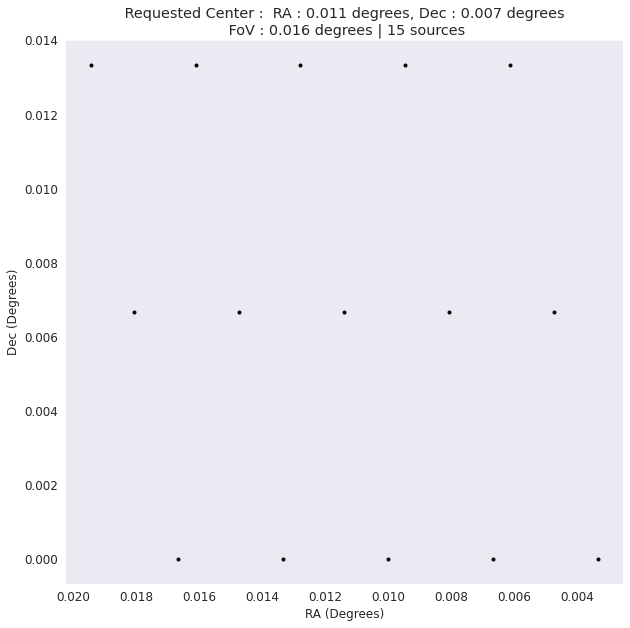

In [100]:
psf = PSF_gen_v2(df=df,axis='off',mode='hcipy',exp_time =10000)
psf.show_field()

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7fa5705cf450>)

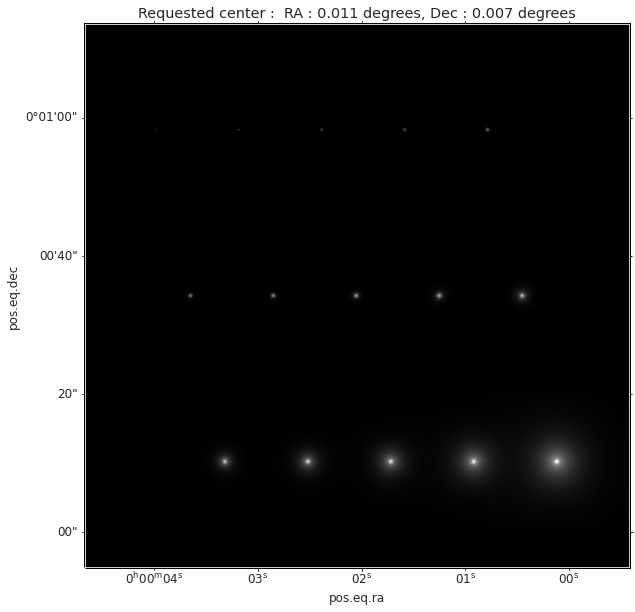

In [101]:
psf.generate_psf()
psf.show_image() # (55, 521)

In [143]:
psf.image.max()/psf.image.min()

1698694.5379825733

In [104]:
psf.writeto('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')

## **Analysis**

In [ ]:
img = plt.hist(psf.bag.ravel(),bins = np.linspace(psf.bag.min(),psf.bag.max(),50));

In [ ]:
psf.bag.mean() , psf.bag.std()

In [ ]:
x = (img[1][:-1] + img[1][1:])/2
y = img[0]

In [ ]:
plt.plot(x,y,'-o')

In [ ]:
psf.sky_bag_flux

In [ ]:
psf = PSF_gen_v2(df=df,axis='off',mode='hcipy',exp_time = 1)
psf.generate_psf()
psf.writeto('test_off.fits')

c          = SkyCoord(df['ra'],df['dec'],unit=u.deg)
data_b_off = fits.open('/content/INSIST/data/output.fits')
wcs        = WCS(data_b_off[0].header)
pix        = wcs.world_to_array_index(c)

position        = [(i,j) for i,j in zip(pix[1],pix[0])]

aperture        = CircularAperture(position, r=0.3/0.1)
ap_pix          = np.count_nonzero(aperture.to_mask()[0])
aperture_bag    = aper.CircularAnnulus(position, r_in = 0.3/0.1, r_out = 0.6/0.1)
bag_pix         = np.count_nonzero(aperture_bag.to_mask()[0])

phot_table_off  = aperture_photometry(data_b_off[0].data, [aperture, aperture_bag])

phot_table_off['sky_flux'] = (ap_pix/bag_pix)*phot_table_off['aperture_sum_1'].value
phot_table_off['flux']     = phot_table_off['aperture_sum_0'].value - (ap_pix/bag_pix)*phot_table_off['aperture_sum_1'].value

phot_table_off['flux_err'] = np.sqrt( (phot_table_off['flux'].value + phot_table_off['sky_flux'].value ))

phot_table_off['SNR']      = (phot_table_off['flux'])/( np.sqrt((phot_table_off['flux'] + phot_table_off['sky_flux'] + psf.DC*ap_pix) + psf.RN**2*ap_pix) )

phot_table_off['mag_in']   = df.mag_nuv
phot_table_off['mag_0.3']  = -2.5*np.log10(phot_table_off['flux'].value/(3945554134.834311*psf.exp_time))
phot_table_off['mag_err']  = 1.087*phot_table_off['flux_err'].value/phot_table_off['flux'].value
phot_table_off

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_0.3,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
1,199.0,199.0,4.121880307679071e-06,1.1679605858607156e-05,4.530881583080362e-06,-4.090012754012915e-07,0.0020302414407353305,-0.00020145450053130423,15,nan,-5395.759325967949


In [ ]:
#psf = PSF_gen_v2(df=df,axis='on',mode='hcipy',exp_time = 1)
#psf.generate_psf()
#psf.writeto('test_on.fits')
c = SkyCoord(df['ra'],df['dec'],unit=u.deg)
data_b_on  = fits.open('/content/INSIST/data/pyxel-examples/tutorial/data/source_n.fits')
wcs        = WCS(data_b_on[0].header)
pix        = wcs.world_to_array_index(c)

position     = [(i,j) for i,j in zip(pix[1],pix[0])]

aperture        = CircularAperture(position, r=0.3/0.1)
ap_pix          = np.count_nonzero(aperture.to_mask()[0])
aperture_bag    = aper.CircularAnnulus(position, r_in = 0.3/0.1, r_out = 0.6/0.1)
bag_pix         = np.count_nonzero(aperture_bag.to_mask()[0])

phot_table_on   = aperture_photometry(data_b_on[0].data, [aperture, aperture_bag])

phot_table_on['sky_flux'] = (ap_pix/bag_pix)*phot_table_on['aperture_sum_1'].value

phot_table_on['flux']     = phot_table_on['aperture_sum_0'].value - phot_table_on['sky_flux'].value

phot_table_on['flux_err'] = np.sqrt( (phot_table_on['flux'].value + phot_table_on['sky_flux'].value ))

phot_table_on['SNR']      = (phot_table_on['flux'].value)/( np.sqrt((phot_table_on['flux'] + phot_table_on['sky_flux'] + psf.DC*ap_pix) + psf.RN**2*ap_pix) )

phot_table_on['mag_in']   = df.mag_nuv
phot_table_on['mag_0.3']  = -2.5*np.log10(phot_table_on['flux'].value/(3639079956.678134*psf.exp_time))
phot_table_on['mag_err']  = 1.087*phot_table_on['flux_err'].value/phot_table_on['flux'].value
phot_table_on

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_0.3,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
1,199.0,199.0,1689566.4087884722,119729.0841428833,46446.62746922197,1643119.7813192501,1299.8332234515597,1264.1004643319793,15,8.363305934423558,0.000859900008481075


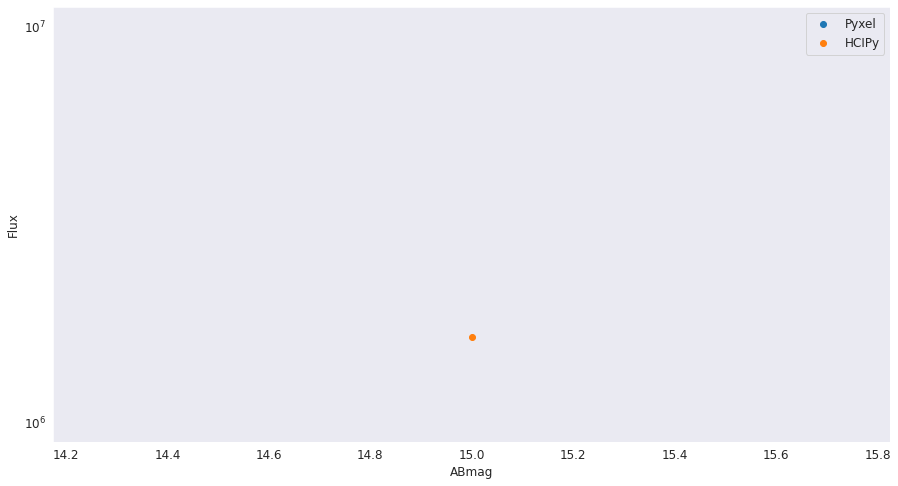

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(phot_table_off['mag_in'].value, phot_table_off['flux'].value, 'o')
plt.plot(phot_table_on['mag_in'].value, phot_table_on['flux'].value, 'o')

plt.legend(['Pyxel', 'HCIPy'])
plt.xlabel('ABmag')
plt.ylabel('Flux')
plt.yscale('log')

Text(0, 0.5, 'HCIPy flux')

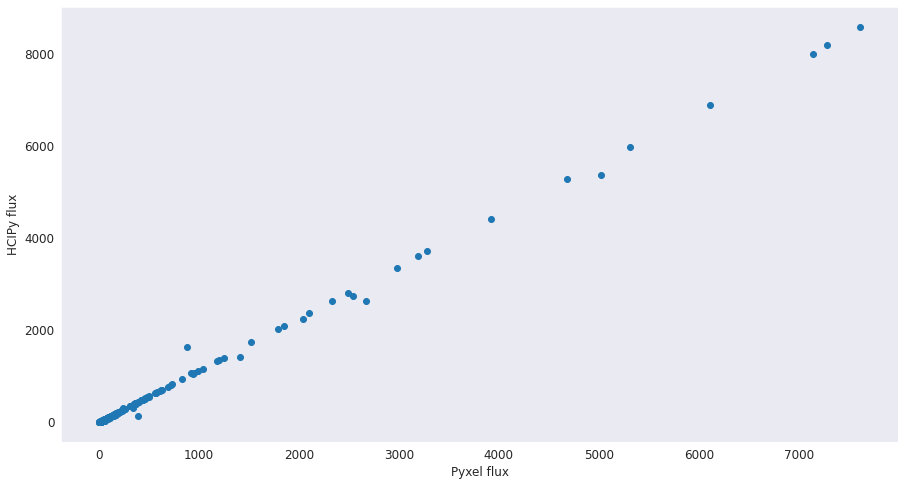

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(phot_table_off['aperture_sum_0'].value, phot_table_on['aperture_sum_0'].value,'o')
plt.xlabel('Pyxel flux')
plt.ylabel('HCIPy flux')

In [ ]:
phot_table_on['diff']  = abs(phot_table_on['mag_in'].value  - phot_table_on['mag_0.3'].value)/phot_table_on['mag_in'].value

phot_table_off['diff'] = abs(phot_table_off['mag_in'].value - phot_table_off['mag_0.3'].value)/phot_table_off['mag_in'].value

In [ ]:
plt.plot(phot_table_off['mag_0.3'].value, phot_table_off['diff'].value,'o')
plt.plot(phot_table_on['mag_0.3'].value, phot_table_on['diff'].value,'o')
plt.legend(['off', 'on'])
plt.xlabel('ABmag')
plt.ylabel('(Input-Output)/Input')

In [ ]:
psf = PSF_gen_v2(df=df,axis='on',mode='hcipy',exp_time=10)
psf.generate_psf()
df_new = phot_table_on.to_pandas()
df_new_on = df_new[ (df_new['diff']>=0.05) & (df_new['SNR']<5) ]
positions = [(i,j) for i,j in zip(df_new_on['xcenter'].values, df_new_on['ycenter'].values)]
apertures     = CircularAperture(positions, r=0.455/0.1)

fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(111)
ax.imshow(psf.image, cmap = 'gray', norm = col.LogNorm())
ax.set_title(f'{len(df_new_on)} Sources highlighted')
for aperture in apertures:
  aperture.plot(ax,color= 'red')

In [ ]:
df_new_on

In [ ]:
psf.writeto('on_axis_M31.fits')

In [ ]:
psf = PSF_gen_v2(df=df,axis='off',mode='hcipy',exp_time =10)
psf.generate_psf()
df_new = phot_table_off.to_pandas()
df_new_off = df_new[ (df_new['diff']>=0.05) & (df_new['SNR']<5) ]
positions = [(i,j) for i,j in zip(df_new_off['xcenter'].values, df_new_off['ycenter'].values)]

apertures     = CircularAperture(positions, r=0.455/0.1)

fig = plt.figure(figsize = (10,10))
ax  = fig.add_subplot(111)
ax.imshow(psf.image, cmap = 'gray', norm = col.LogNorm())
ax.set_title(f'{len(df_new_off)} Sources highlighted')
for aperture in apertures:
  aperture.plot(ax,color= 'red')

In [ ]:
psf.writeto('off_axis_M31.fits')

In [ ]:
df_new_on

In [ ]:
df_new_off